<a href="https://colab.research.google.com/github/wep69/GeoModels-page/blob/master/Pilar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap ee dask matplotlib numpy xarray wxee rasterio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.5 MB/s eta 0:00:00
  Created wheel for ee: filename=ee-0.2-py3-none-any.whl size=3655 sha256=8453ee5dfcddc6d8ee9f28dc8c6cbf5fd8b880cd3302cf023ee0f6019e2b4318
  Stored in directory: /root/.cache/pip/wheels/cb/b1/a5/d16d395d190f232181add4c4af67a74c2de272875759921aef
Successfully built ee


In [2]:
!pip install shapely

In [3]:
import os

# Set the number of threads to use
os.environ['OMP_NUM_THREADS'] = '16'

In [ ]:
# @title Texto de título padrão
# VEr aqui https://github.com/leftfield-geospatial/geedim
#Primeiro geemap para não ter problemas com ee.Initialize
import geemap

m = geemap.Map()
m
import ee
#ee.Authenticate()
ee.Initialize()

#import geemap

from dask.distributed import Client
client = Client(n_workers=3, threads_per_worker=2)


import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

#pilar=geemap.geojson_to_ee("F:/Meu Drive/Vários/Pilar/map.geojson").geometry()   #283    257

pilar=geemap.geojson_to_ee("I:/Meu Drive/Vários/Pilar/pilar_filtrada_jica.geojson").geometry()
#paufarray= xr.open_dataset("D:/Walter/R/EVI/Pauferro/SARdados.nc")





In [ ]:
# Somente no contorno da área


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=3, threads_per_worker=2)

#pilar = geemap.geojson_to_ee("F:/Meu Drive/Vários/Pilar/map.geojson").geometry()

# Defina o intervalo de anos
start_year = 1983
end_year = 2023

def monthly_mean_per_year(image_collection, start_year, end_year):
    all_mean_images = []
    for year in range(start_year, end_year + 1):
        images_in_year = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        for month in range(1, 13):
            # Calcular a média mensal
            mean_image = images_in_year.filter(ee.Filter.calendarRange(month, month, 'month')).mean()

            # Copiar a propriedade system:time_start da primeira imagem do mês
            first_image = images_in_year.filter(ee.Filter.calendarRange(month, month, 'month')).first()
            mean_image = mean_image.set('system:time_start', first_image.get('system:time_start'))

            # Definir propriedades adicionais
            mean_image = mean_image.set('month', month).set('year', year)
            all_mean_images.append(mean_image)

    return ee.ImageCollection(all_mean_images)

# Filtrar a coleção de imagens pela localização
agua = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").filterBounds(pilar).select("soil")

# Calcular a média mensal para cada ano
aguapilar = monthly_mean_per_year(agua, start_year, end_year)

In [ ]:
aguapilar


In [ ]:
#  ESTE é o melhor

#pilar = geemap.geojson_to_ee("F:/Meu Drive/Vários/Pilar/map.geojson").geometry()



def monthly_mean_per_year(image_collection, start_year, end_year, interval):
    all_mean_images = []
    # Iterar através dos anos com o intervalo especificado
    for year in range(start_year, end_year + 1, interval):
        images_in_year = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        for month in range(1, 13):
            # Calcular a média mensal
            mean_image = images_in_year.filter(ee.Filter.calendarRange(month, month, 'month')).mean()

            # Copiar a propriedade system:time_start da primeira imagem do mês
            first_image = images_in_year.filter(ee.Filter.calendarRange(month, month, 'month')).first()
            if first_image is not None:
                mean_image = mean_image.set('system:time_start', first_image.get('system:time_start'))


            #first_image = images_in_year.filter(ee.Filter.calendarRange(month, month, 'month')).first()
            #mean_image = mean_image.set('system:time_start', first_image.get('system:time_start'))

            # Definir propriedades adicionais
            mean_image = mean_image.set('month', month).set('year', year)
            all_mean_images.append(mean_image)

    return ee.ImageCollection(all_mean_images)




In [ ]:
# Filtrar a coleção de imagens pela localização
# Defina o intervalo de anos e o intervalo de repetição
start_year = 1983
end_year = 2023
interval = 5
agua = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").filterBounds(pilar).select("soil")

# Calcular a média mensal para cada ano, com intervalo de 5 anos
aguapilar = monthly_mean_per_year(agua, start_year, end_year, interval)

In [ ]:
aguapilar

https://pysmm.readthedocs.io/en/latest/


In [ ]:
#scale para wxee # Errado por que não é a original
aguapilar.first().projection().nominalScale()

Requesting data:   0%|          | 0/108 [00:00<?, ?it/s]

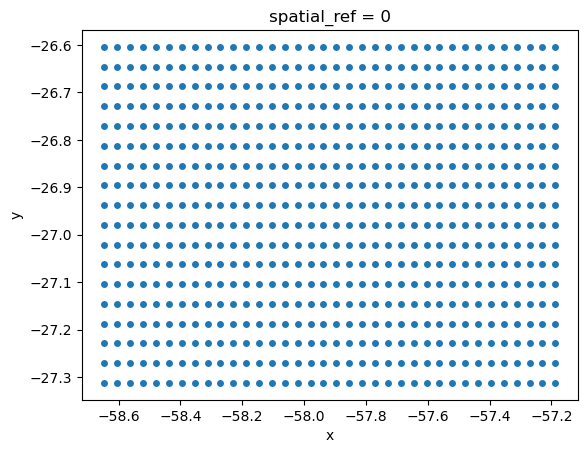

In [ ]:
import rasterio
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

aguaarray = aguapilar.wx.to_xarray(region=pilar, crs=crs, scale=4638.3)


aguaarray.to_netcdf("I:/Meu Drive/Vários/Pilar/aguasolo_23.nc")

import xarray as xr

aguadf=aguaarray.to_dataframe()

aguaarray.plot.scatter(x='x',y='y')


In [ ]:
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"
soilhum = sarpilar.wx.to_xarray(region=pilar, crs=crs, scale=231.91)

soilhum.to_netcdf("F:/Meu Drive/Vários/Pilar/agua_2.nc")


soilhumdf=soilhum.to_dataframe()

soilhum.plot.scatter(x='x',y='y')


In [ ]:
soilhum

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import calendar

# Substitua data pelo nome da sua variável xarray.Dataset
data = aguaarray

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
vmin = data['soil'].min().values
vmax = data['soil'].max().values
# Anos para os quais você deseja criar os gráficos
years_to_plot = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2023]

# Nome do arquivo PDF para salvar os gráficos
pdf_filename = 'soil_plots-23.pdf'

# Criar um arquivo PDF para salvar os gráficos
with PdfPages(pdf_filename) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        fig.suptitle(f'Humedad del Suelo (mm) para {year}', fontsize=16)

        # Filtrar os dados para o ano atual
        data_year = data.sel(time=str(year))

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data = data_year['soil'].sel(time=f"{year}-{month:02d}-01").values
            c = ax.pcolormesh(data['x'], data['y'], soil_data, shading='auto', cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.6)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Gráficos salvos em {pdf_filename}')



Gráficos salvos em soil_plots-23.pdf


In [ ]:
from shapely.geometry import shape, Point


# Substitua data pelo nome da sua variável xarray.Dataset
data = aguaarray

# Carregar a geometria do Pilar
pilar_geojson = "I:/Meu Drive/Vários/Pilar/pilar_filtrada_jica.geojson"
pilar = geemap.geojson_to_ee(pilar_geojson).geometry()
pilar_shape = shape(pilar.getInfo())

# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
vmin = data['soil'].min().values
vmax = data['soil'].max().values

# Anos para os quais você deseja criar os gráficos
years_to_plot = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2023]

# Nome do arquivo PDF para salvar os gráficos
pdf_filename = 'soil_plots-23_Contorno.pdf'

# Criar um arquivo PDF para salvar os gráficos
with PdfPages(pdf_filename) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        fig.suptitle(f'Humedad del Suelo (mm) para {year}', fontsize=16)

        # Filtrar os dados para o ano atual
        data_year = data.sel(time=str(year))

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data = data_year['soil'].sel(time=f"{year}-{month:02d}-01").values

            # Criar uma máscara usando a geometria do Pilar
            x_coords, y_coords = np.meshgrid(data['x'].values, data['y'].values)
            mask = np.array([pilar_shape.contains(Point(x, y)) for x, y in zip(x_coords.flatten(), y_coords.flatten())])
            mask = mask.reshape(x_coords.shape)

            # Aplicar a máscara aos dados do solo
            soil_data = np.where(mask, soil_data, np.nan)

            c = ax.pcolormesh(data['x'], data['y'], soil_data, shading='auto', cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.6)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Gráficos salvos em {pdf_filename}')

In [ ]:
import os

# Set the number of threads to use
os.environ['OMP_NUM_THREADS'] = '16'  # Replace 16 with the number of cores you want to use

# Import the necessary libraries
from shapely.geometry import shape, Point
import xarray as xr

# Load your data
data = xr.open_dataset('your_data.nc')

# Load the geometry of Pilar
pilar_geojson = "I:/Meu Drive/Vários/Pilar/pilar_filtrada_jica.geojson"
pilar = geemap.geojson_to_ee(pilar_geojson).geometry()
pilar_shape = shape(pilar.getInfo())

# Names of the months in Spanish
month_names = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']

In [ ]:
# Diferenças percentuais entre 2023 - 1983
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import geemap
from shapely.geometry import shape, Point
import numpy as np

# Substitua data pelo nome da sua variável xarray.Dataset
data = aguaarray

# Carregar a geometria do Pilar
pilar_geojson = "I:/Meu Drive/Vários/Pilar/pilar_filtrada_jica.geojson"
pilar = geemap.geojson_to_ee(pilar_geojson).geometry()
pilar_shape = shape(pilar.getInfo())

# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
vmin = data['soil'].min().values
vmax = data['soil'].max().values

# Anos para os quais você deseja criar os gráficos
years_to_plot = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2023]

# Nome do arquivo PDF para salvar os gráficos
pdf_filename = 'soil_plots-23_Contorno.pdf'

# Criar um arquivo PDF para salvar os gráficos
with PdfPages(pdf_filename) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        fig.suptitle(f'Humedad del Suelo (mm) para {year}', fontsize=16)

        # Filtrar os dados para o ano atual
        data_year = data.sel(time=str(year))

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data = data_year['soil'].sel(time=f"{year}-{month:02d}-01").values

            # Criar uma máscara usando a geometria do Pilar
            x_coords, y_coords = np.meshgrid(data['x'].values, data['y'].values)
            mask = np.array([pilar_shape.contains(Point(x, y)) for x, y in zip(x_coords.flatten(), y_coords.flatten())])
            mask = mask.reshape(x_coords.shape)

            # Aplicar a máscara aos dados do solo
            soil_data = np.where(mask, soil_data, np.nan)

            c = ax.pcolormesh(data['x'], data['y'], soil_data, shading='auto', cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.6)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Gráficos salvos em {pdf_filename}')

# Calcular a diferença percentual entre 1983 e 2023
data_1983 = data.sel(time='1983')
data_2023 = data.sel(time='2023')

# Criar um novo arquivo PDF para salvar os gráficos de diferença percentual
pdf_filename_diff = 'soil_diff_1983_2023.pdf'

with PdfPages(pdf_filename_diff) as pdf:
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle('Diferença Percentual de Humedad del Suelo (1983 vs 2023)', fontsize=16)

    for month in range(1, 13):
        ax = axs[(month - 1) // 3, (month - 1) % 3]
        soil_1983 = data_1983['soil'].sel(time=f"1983-{month:02d}-01").values
        soil_2023 = data_2023['soil'].sel(time=f"2023-{month:02d}-01").values

        # Criar uma máscara usando a geometria do Pilar
        x_coords, y_coords = np.meshgrid(data['x'].x_coords, y_coords = np.meshgrid(data['x'].values, data['y'].values)
        mask = np.array([pilar_shape.contains(Point(x, y)) for x, y in zip(x_coords.flatten(), y_coords.flatten())])
        mask = mask.reshape(x_coords.shape)

        # Aplicar a máscara aos dados de 1983 e 2023
        soil_1983 = np.where(mask, soil_1983, np.nan)
        soil_2023 = np.where(mask, soil_2023, np.nan)

        # Calcular a diferença percentual
        diff_percent = ((soil_2023 - soil_1983) / soil_1983) * 100

        # Criar o gráfico de diferença percentual
        c = ax.pcolormesh(data['x'], data['y'], diff_percent, shading='auto', cmap='RdBu', vmin=-100, vmax=100, alpha=0.6)
        plt.colorbar(c, ax=ax)
        ax.set_title(f'{months_es[month - 1]}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    pdf.savefig(fig)
    plt.close(fig)

print(f'Gráficos de diferença percentual salvos em {pdf_filename_diff}')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

data = aguaarray
# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Anos para os quais você deseja criar os gráficos
years_to_plot = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2021]

# Nome do arquivo PDF para salvar os gráficos
pdf_filename = 'soil_maps.pdf'

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
vmin = data['soil'].min().values
vmax = data['soil'].max().values

# Criar um arquivo PDF para salvar os gráficos
with PdfPages(pdf_filename) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))
        fig.suptitle(f'Humedad del Suelo (mm) para {year}', fontsize=16)

        # Filtrar os dados para o ano atual
        data_year = data.sel(time=str(year))

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data = data_year['soil'].sel(time=f"{year}-{month:02d}-01").values

            # Usar contourf com vmin e vmax para criar o mapa baseado nas coordenadas
            c = ax.contourf(data['x'], data['y'], soil_data, cmap='RdBu', alpha=0.6, vmin=vmin, vmax=vmax)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('Longitud')
            ax.set_ylabel('Latitud')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Mapas salvos em {pdf_filename}')



In [ ]:
#Falta ajustar
import matplotlib.gridspec as gridspec

# Definir os anos desejados
desired_years = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2021]
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos globais
vmin = data['soil'].min()
vmax = data['soil'].max()

for year in desired_years:
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle(f'Humedad del Suelo (mm) para {year}', fontsize=16)

    # Definir a grade para acomodar as subfiguras e a barra de cores
    gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 1])

    # Filtrar os dados para o ano atual e iterar pelos meses
    for idx, month in enumerate(range(1, 13)):
        ax = plt.subplot(gs[idx // 3, idx % 3])

        # Defina o intervalo de data para o mês desejado
        start_date = f'{year}-{month:02d}-01'
        end_date = f'{year}-{month:02d}-{data["time"].dt.days_in_month.sel(time=start_date).item()}'

        # Filtrar os dados para o mês atual
        soil_data = data['soil'].sel(time=slice(start_date, end_date)).mean(dim='time').data


        # Plotar os dados usando a mesma escala de cores para todas as subparcelas
        c = ax.pcolormesh(data['x'], data['y'], soil_data, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax, alpha=0.6)

        # Adicionar o título do mês
        ax.set_title(months_es[idx])

    # Adicionar uma única barra de cores para representar a escala comum
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    fig.colorbar(c, cax=cbar_ax, orientation='horizontal')

    # Salvar a figura em PDF
    plt.savefig(f'soil_moisture_{year}.pdf')

plt.show()



MSi baseado em DOI: 10.4172/2469-4134.1000200
Landsat B5/B4

In [ ]:
# Define os anos que você quer incluir
selected_years = [1984, 1988, 1993, 1998, 2003, 2008]

# Função para calcular a razão entre as bandas SR_B5 e SR_B4
def calculate_ratio(image):
    ratio = image.select('SR_B5').divide(image.select('SR_B4')).rename('MSI')
    return image.addBands(ratio).select(['MSI'])  # Retornar apenas a banda de razão

 #Função para filtrar imagens de anos selecionados
def filter_by_years(image_collection, years):
    filtered_collection = ee.ImageCollection([])
    for year in years:
        yearly_images = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        filtered_collection = filtered_collection.merge(yearly_images)
    return filtered_collection

# Filtrar a coleção de imagens pelos anos selecionados e calcular a razão
aguam = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(pilar)
aguam = filter_by_years(aguam, selected_years).map(calculate_ratio)

#aguam = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(pilar).select(['SR_B4', 'SR_B5']).map(calculate_ratio)



In [ ]:
# Define os anos que você quer incluir
selected_years = [2013, 2018,2022]

# Função para calcular a razão entre as bandas SR_B5 e SR_B4
def calculate_ratio(image):
    ratio = image.select('SR_B5').divide(image.select('SR_B4')).rename('MSI')
    return image.addBands(ratio).select(['MSI'])  # Retornar apenas a banda de razão

 #Função para filtrar imagens de anos selecionados
def filter_by_years(image_collection, years):
    filtered_collection = ee.ImageCollection([])
    for year in years:
        yearly_images = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        filtered_collection = filtered_collection.merge(yearly_images)
    return filtered_collection

# Filtrar a coleção de imagens pelos anos selecionados e calcular a razão
aguam2 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(pilar)
aguam2 = filter_by_years(aguam2, selected_years).map(calculate_ratio)

In [ ]:
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

aguamarray = aguam.wx.to_xarray(region=pilar, crs=crs, scale=120)


aguamarray.to_netcdf("F:/Meu Drive/Vários/Pilar/agua_3.nc")

import xarray as xr

aguadf=aguamarray.to_dataframe()

aguamarray.plot.scatter(x='x',y='y')

In [ ]:
aguamarray2= aguam2.wx.to_xarray(region=pilar, crs=crs, scale=120)


aguamarray2.to_netcdf("F:/Meu Drive/Vários/Pilar/agua_4.nc")

aguadf=aguamarray.to_dataframe()

aguamarray2.plot.scatter(x='x',y='y')

In [ ]:
aguamarray=xr.open_dataset("F:/Meu Drive/Vários/Pilar/agua_3.nc")
aguamarray

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import calendar

# Substitua data pelo nome da sua variável xarray.Dataset
data = aguamarray

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
# Anos para os quais você deseja criar os gráficos
years_to_plot = [1984, 1988, 1993, 1998, 2003, 2008]

import numpy as np
import xarray as xr
coarsen_factor = 4

# Filtrar os dados para os anos selecionados
# Coarsen os dados usando a média
data_selected_years = data.sel(time=np.isin(data['time.year'], years_to_plot))

# Calcular a média mensal para cada mês e cada ano selecionado
monthly_means_per_year = data_selected_years.groupby('time.year').map(lambda group: group.groupby('time.month').mean(dim='time'))
monthly_means_per_year = monthly_means_per_year.coarsen(x=coarsen_factor, y=coarsen_factor, boundary='trim').mean()

# Extraia as coordenadas coarsened
x_coarsened = monthly_means_per_year['x'].values
y_coarsened = monthly_means_per_year['y'].values
# Limitar os valores de MSI a 1
monthly_means_per_year['MSI'] = xr.where(monthly_means_per_year['MSI'] > 1, np.nan, monthly_means_per_year['MSI'])
vmin = monthly_means_per_year['MSI'].min().values
vmax = monthly_means_per_year['MSI'].max().values


# Nome do arquivo PDF para salvar os gráficos das médias mensais
pdf_filename_means = 'MSI_monthly_means.pdf'

# Criar um arquivo PDF para salvar os gráficos das médias mensais
with PdfPages(pdf_filename_means) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(10, 25))
        fig.suptitle(f'Medias mensuales de IEH para {year}', fontsize=16)
        data_year = monthly_means_per_year.sel(year=year)

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data_mean = data_year['MSI'].sel(month=month).values

            # Substituir valores NaN por branco na figura
            masked_data = np.ma.masked_where(np.isnan(soil_data_mean), soil_data_mean)
            cmap = plt.cm.RdBu
            #cmap.set_bad(color='white')

            c = ax.pcolormesh(x_coarsened, y_coarsened, masked_data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Gráficos das médias mensais salvos em {pdf_filename_means}')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import calendar

# Substitua data pelo nome da sua variável xarray.Dataset
data = aguamarray

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# Nomes dos meses em espanhol
months_es = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

# Encontrar os valores mínimos e máximos em todo o conjunto de dados
# Anos para os quais você deseja criar os gráficos
years_to_plot = [1984, 1988, 1993, 1998, 2003, 2008]

import numpy as np
import xarray as xr
coarsen_factor = 4

# Filtrar os dados para os anos selecionados
# Coarsen os dados usando a média
data_selected_years = data.sel(time=np.isin(data['time.year'], years_to_plot))

# Calcular a média mensal para cada mês e cada ano selecionado
monthly_means_per_year = data_selected_years.groupby('time.year').map(lambda group: group.groupby('time.month').mean(dim='time'))
monthly_means_per_year = monthly_means_per_year.coarsen(x=coarsen_factor, y=coarsen_factor, boundary='trim').mean()

# Extraia as coordenadas coarsened
x_coarsened = monthly_means_per_year['x'].values
y_coarsened = monthly_means_per_year['y'].values
# Limitar os valores de MSI a 1
monthly_means_per_year['MSI'] = xr.where(monthly_means_per_year['MSI'] > 1, np.nan, monthly_means_per_year['MSI'])
vmin = monthly_means_per_year['MSI'].min().values
vmax = monthly_means_per_year['MSI'].max().values


# Nome do arquivo PDF para salvar os gráficos das médias mensais
pdf_filename_means = 'MSI_monthly_means.pdf'

# Criar um arquivo PDF para salvar os gráficos das médias mensais
with PdfPages(pdf_filename_means) as pdf:
    for year in years_to_plot:
        fig, axs = plt.subplots(4, 3, figsize=(8, 12))
        fig.suptitle(f'Medias mensuales de IEH para {year}', fontsize=16)
        data_year = monthly_means_per_year.sel(year=year)

        # Iterar através dos meses e criar os gráficos
        for month in range(1, 13):
            ax = axs[(month - 1) // 3, (month - 1) % 3]
            soil_data_mean = data_year['MSI'].sel(month=month).values

            # Substituir valores NaN por branco na figura
            masked_data = np.ma.masked_where(np.isnan(soil_data_mean), soil_data_mean)
            cmap = plt.cm.RdBu
            cmap.set_bad(color='white')

            c = ax.contourf(x_coarsened, y_coarsened, masked_data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6)
            plt.colorbar(c, ax=ax)
            ax.set_title(f'{months_es[month - 1]}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        pdf.savefig(fig)
        plt.close(fig)

print(f'Gráficos das médias mensais salvos em {pdf_filename_means}')


In [ ]:
monthly_means_per_year.to_netcdf("F:/Meu Drive/Vários/Pilar/MSI_1.nc")
#aguamarray. ("F:/Meu Drive/Vários/Pilar/MSi_mensual.xlsx", index=False)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Carregar o mapa do Departamento de Pilar (substitua com o caminho correto do arquivo)
pilar_map = gpd.read_file("path/to/pilar_shapefile.shp")

# Definir a projeção (altere conforme necessário)
projection = ccrs.PlateCarree()

# Criar a figura e o eixo
fig, ax = plt.subplots(subplot_kw={'projection': projection})

# Plotar o mapa do Departamento de Pilar
pilar_map.plot(ax=ax, edgecolor='black')

# Plotar os dados de humidade do solo (ajuste conforme necessário)
# Este é um exemplo; substitua com seu próprio código de plotagem
ax.pcolormesh(data['x'], data['y'], soil_data, shading='auto', cmap='RdBu', vmin=vmin, vmax=vmax, alpha=0.6)

# Adicionar detalhes adicionais, como título, etiquetas, etc.
ax.set_title("Humedad del Suelo (mm) - Pilar, Paraguai")

# Exibir o gráfico
plt.show()


In [ ]:
import xarray as xr
dados=xr.open_dataset("F:/Meu Drive/Vários/Pilar/Completo.nc")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np


# Definindo os valores mínimos e máximos para a coloração
vmin = dataset['volumetric_soil_water_layer_1_max'].min().values
vmax = dataset['volumetric_soil_water_layer_1_max'].max().values

# Especificando os anos desejados
selected_years = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2022]

# Criando um arquivo PDF para salvar os gráficos
with PdfPages('histograms2.pdf') as pdf:
    # Iniciando uma nova figura para a grade de subplots 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    # Determinando os limites globais para os eixos x e y
    global_ylim = 0  # Inicializando o limite superior do eixo y
    # Iterando pelos anos selecionados
    for i, year in enumerate(selected_years):
        # Selecionando os dados para o ano atual
        data_year = dataset['volumetric_soil_water_layer_1_max'].sel(time=str(year))

        # Ignorando as coordenadas x, y e os meses, somente os anos
        values = data_year.values.flatten()

        # Criando o histograma no subplot correspondente com density=True
        n, bins, patches = axes[i].hist(values, bins=20, edgecolor='black', density=True)
        # Atualizando o limite global do eixo y, se necessário
        global_ylim = max(global_ylim, np.max(n))
        axes[i].set_title(f'{year}')
        axes[i].set_xlabel('CVAS (0-7 cm)')
        axes[i].set_ylabel('Densidad')  # Atualizado para 'Density'

        # Colorindo as barras usando o mapa de cores 'RdBu'
        for j in range(len(patches)):
            plt.setp(patches[j], 'facecolor', plt.cm.RdBu((bins[j] - vmin) / (vmax - vmin)))

    # Configurando os mesmos limites de eixo x e y para todas as sub-figuras
        for ax in axes:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(0, global_ylim)
    # Adicionando uma barra de cores na parte inferior da página
    cax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax, orientation='horizontal', label='CVAS (0-7 cm)')

    # Organizando o layout e salvando a página atual no arquivo PDF
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    pdf.savefig()
    plt.close()

print("PDF gerado com sucesso!")


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np


# Definindo os valores mínimos e máximos para a coloração
vmin = dataset['volumetric_soil_water_layer_1_max'].min().values
vmax = dataset['volumetric_soil_water_layer_1_max'].max().values

# Especificando os anos desejados
selected_years = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2022]

# Criando um arquivo PDF para salvar os gráficos
with PdfPages('histograms3.pdf') as pdf:
    # Iniciando uma nova figura para a grade de subplots 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    # Determinando os limites globais para os eixos x e y
    global_ylim = 0  # Inicializando o limite superior do eixo y
    # Iterando pelos anos selecionados
    for i, year in enumerate(selected_years):
        # Selecionando os dados para o ano atual
        data_year = dataset['volumetric_soil_water_layer_1'].sel(time=str(year))

        # Ignorando as coordenadas x, y e os meses, somente os anos
        values = data_year.values.flatten()

        # Criando o histograma no subplot correspondente com density=True
        n, bins, patches = axes[i].hist(values, bins=20, edgecolor='black', density=True)
        # Atualizando o limite global do eixo y, se necessário
        global_ylim = max(global_ylim, np.max(n))
        axes[i].set_title(f'{year}')
        axes[i].set_xlabel('CVAS (0-7 cm)')
        axes[i].set_ylabel('Densidad')  # Atualizado para 'Density'

        # Colorindo as barras usando o mapa de cores 'RdBu'
        for j in range(len(patches)):
            plt.setp(patches[j], 'facecolor', plt.cm.RdBu((bins[j] - vmin) / (vmax - vmin)))

    # Configurando os mesmos limites de eixo x e y para todas as sub-figuras
        for ax in axes:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(0, global_ylim)
    # Adicionando uma barra de cores na parte inferior da página
    cax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax, orientation='horizontal', label='CVAS (0-7 cm)')

    # Organizando o layout e salvando a página atual no arquivo PDF
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    pdf.savefig()
    plt.close()

print("PDF gerado com sucesso!")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np


# Definindo os valores mínimos e máximos para a coloração
vmin = dataset['volumetric_soil_water_layer_1_max'].min().values
vmax = dataset['volumetric_soil_water_layer_1_max'].max().values

# Especificando os anos desejados
selected_years = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2022]

# Criando um arquivo PDF para salvar os gráficos
with PdfPages('histograms6.pdf') as pdf:
    # Iniciando uma nova figura para a grade de subplots 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    # Determinando os limites globais para os eixos x e y
    global_ylim = 0  # Inicializando o limite superior do eixo y
    # Iterando pelos anos selecionados
    for i, year in enumerate(selected_years):
        # Selecionando os dados para o ano atual
        data_year = dataset['volumetric_soil_water_layer_4'].sel(time=str(year))

        # Ignorando as coordenadas x, y e os meses, somente os anos
        values = data_year.values.flatten()

        # Criando o histograma no subplot correspondente com density=True
        n, bins, patches = axes[i].hist(values, bins=20, edgecolor='black', density=True)
        # Atualizando o limite global do eixo y, se necessário
        global_ylim = max(global_ylim, np.max(n))
        axes[i].set_title(f'{year}')
        axes[i].set_xlabel('CVAS (100-289 cm)')
        axes[i].set_ylabel('Densidad')  # Atualizado para 'Density'

        # Colorindo as barras usando o mapa de cores 'RdBu'
        for j in range(len(patches)):
            plt.setp(patches[j], 'facecolor', plt.cm.RdBu((bins[j] - vmin) / (vmax - vmin)))

    # Configurando os mesmos limites de eixo x e y para todas as sub-figuras
        for ax in axes:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(0, global_ylim)
    # Adicionando uma barra de cores na parte inferior da página
    cax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax, orientation='horizontal', label='CVAS (100-289 cm)')

    # Organizando o layout e salvando a página atual no arquivo PDF
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    pdf.savefig()
    plt.close()

print("PDF gerado com sucesso!")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np


# Definindo os valores mínimos e máximos para a coloração
vmin = dataset['volumetric_soil_water_layer_1_max'].min().values
vmax = dataset['volumetric_soil_water_layer_1_max'].max().values

# Especificando os anos desejados
selected_years = [1983, 1988, 1993, 1998, 2003, 2008, 2013, 2018, 2022]

# Criando um arquivo PDF para salvar os gráficos
with PdfPages('histograms7.pdf') as pdf:
    # Iniciando uma nova figura para a grade de subplots 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    # Determinando os limites globais para os eixos x e y
    global_ylim = 0  # Inicializando o limite superior do eixo y
    # Iterando pelos anos selecionados
    for i, year in enumerate(selected_years):
        # Selecionando os dados para o ano atual
        data_year = dataset['volumetric_soil_water_layer_4'].sel(time=str(year))

        # Ignorando as coordenadas x, y e os meses, somente os anos
        values = data_year.values.flatten()

        # Criando o histograma no subplot correspondente com density=True
        n, bins, patches = axes[i].hist(values, bins=10, edgecolor='black', density=True)
        # Calculando os percentuais para cada bin
        percent = n * 100



        # Atualizando o limite global do eixo y, se necessário
        global_ylim = max(global_ylim, np.max(n))
        axes[i].set_title(f'{year}')
        axes[i].set_xlabel('CVAS (100-289 cm)')
        axes[i].set_ylabel('Densidad')  # Atualizado para 'Density'

        # Colorindo as barras usando o mapa de cores 'RdBu'
        for j in range(len(patches)):
            plt.setp(patches[j], 'facecolor', plt.cm.RdBu((bins[j] - vmin) / (vmax - vmin)))
            # Adicionando os percentuais como anotações nas figuras
        for j in range(len(patches)):
            axes[i].annotate(f'{percent[j]:.1f}%', xy=(bins[j]+0.025, percent[j]),
                             xytext=(0,0), textcoords='offset points',
                             va='bottom', ha='center', fontsize=6)

    # Configurando os mesmos limites de eixo x e y para todas as sub-figuras
        for ax in axes:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(0, global_ylim)
    # Adicionando uma barra de cores na parte inferior da página
    cax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax, orientation='horizontal', label='CVAS (100-289 cm)')

    # Organizando o layout e salvando a página atual no arquivo PDF
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    pdf.savefig()
    plt.close()

print("PDF gerado com sucesso!")

MODIS Land Cover Type Yearly Global 500m



In [ ]:
# Define os anos que você quer incluir
selected_years = [2001, 2006,2011,2016, 2021]


 #Função para filtrar imagens de anos selecionados
def filter_by_years(image_collection, years):
    filtered_collection = ee.ImageCollection([])
    for year in years:
        yearly_images = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        filtered_collection = filtered_collection.merge(yearly_images)
    return filtered_collection

# Filtrar a coleção de imagens pelos anos selecionados e calcular a razão
#cover = ee.ImageCollection("MODIS/061/MCD12Q1").filterBounds(pilar).select('LC_Type1')
#cover = filter_by_years(cover, selected_years)
#FAO
cover = ee.ImageCollection("MODIS/061/MCD12Q1").filterBounds(pilar).select('LC_Prop3')
cover = filter_by_years(cover, selected_years)


In [ ]:
cover

In [ ]:
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

coverarray = cover.wx.to_xarray(region=pilar, crs=crs, scale=500)


#coverarray.to_netcdf("F:/Meu Drive/Vários/Pilar/Cover.nc")
coverarray.to_netcdf("F:/Meu Drive/Vários/Pilar/Cover_FAO.nc")

import xarray as xr

coverdf=coverarray.to_dataframe()



In [ ]:
coverarray

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors

# Carregar os dados

dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
class_table = {
    1: ['#05450a', 'Bosques de Coníferas Siempreverdes'],
    2: ['#086a10', 'Bosques de Hojas Anchas Siempreverdes'],
    3: ['#54a708', 'Bosques de Coníferas Caducifolias'],
    4: ['#78d203', 'Bosques de Hojas Anchas Caducifolias'],
    5: ['#009900', 'Bosques Mixtos'],
    6: ['#c6b044', 'Matorrales Cerrados'],
    7: ['#dcd159', 'Matorrales Abiertos'],
    8: ['#dade48', 'Sabanas Arborícolas'],
    9: ['#fbff13', 'Sabanas'],
    10: ['#b6ff05', 'Pastizales'],
    11: ['#27ff87', 'Humedales Permanentes'],
    12: ['#c24f44', 'Tierras de Cultivo'],
    13: ['#a5a5a5', 'Áreas Urbanas y Construidas'],
    14: ['#ff6d4c', 'Mosaicos de Cultivo/Vegetación Natural'],
    15: ['#69fff8', 'Nieve y Hielo Permanentes'],
    16: ['#f9ffa4', 'Áreas Desnudas'],
    17: ['#1c0dff', 'Cuerpos de Agua']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['LC_Type1'].sel(time=time)

        # Criar um novo gráfico
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes
        cmap = mcolors.ListedColormap([class_table[val][0] for val in class_table])
        norm = mcolors.BoundaryNorm(list(class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(class_table.keys()))
        cbar.set_ticklabels([class_table[val][1] for val in class_table])

         # Diminuir a fonte da legenda da barra de cores
        cbar.ax.tick_params(labelsize=6)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors

# Carregar os dados
# Substitua 'seuarquivo.nc' pelo caminho do seu arquivo de dados
dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
class_table = {
    1: ['#05450a', 'Bosques de Coníferas Siempreverdes'],
    2: ['#086a10', 'Bosques de Hojas Anchas Siempreverdes'],
    3: ['#54a708', 'Bosques de Coníferas Caducifolias'],
    4: ['#78d203', 'Bosques de Hojas Anchas Caducifolias'],
    5: ['#009900', 'Bosques Mixtos'],
    6: ['#c6b044', 'Matorrales Cerrados'],
    7: ['#dcd159', 'Matorrales Abiertos'],
    8: ['#dade48', 'Sabanas Arborícolas'],
    9: ['#fbff13', 'Sabanas'],
    10: ['#b6ff05', 'Pastizales'],
    11: ['#27ff87', 'Humedales Permanentes'],
    12: ['#c24f44', 'Tierras de Cultivo'],
    13: ['#a5a5a5', 'Áreas Urbanas y Construidas'],
    14: ['#ff6d4c', 'Mosaicos de Cultivo/Vegetación Natural'],
    15: ['#69fff8', 'Nieve y Hielo Permanentes'],
    16: ['#f9ffa4', 'Áreas Desnudas'],
    17: ['#1c0dff', 'Cuerpos de Agua']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['LC_Type1'].sel(time=time)

        # Verificar quais classes estão presentes nos dados
        unique_classes = np.unique(data_time.values)

        # Filtrar a tabela de classes para incluir apenas as classes presentes nos dados
        filtered_class_table = {k: v for k, v in class_table.items() if k in unique_classes}

        # Criar um novo gráfico com tamanho aumentado
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes filtrada
        cmap = mcolors.ListedColormap([val[0] for val in filtered_class_table.values()])
        norm = mcolors.BoundaryNorm(list(filtered_class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(filtered_class_table.keys()))
        cbar.set_ticklabels([val[1] for val in filtered_class_table.values()])

        # Diminuir a fonte da legenda da barra de cores e rotacionar as legendas em 45 graus
        cbar.ax.tick_params(labelsize=6)
        for label in cbar.ax.get_xticklabels():
            label.set_rotation(45)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import numpy as np

# Carregar os dados
# Substitua 'seuarquivo.nc' pelo caminho do seu arquivo de dados
dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
class_table = {
    1: ['#05450a', 'Bosques de Coníferas Siempreverdes'],
    2: ['#086a10', 'Bosques de Hojas Anchas Siempreverdes'],
    3: ['#54a708', 'Bosques de Coníferas Caducifolias'],
    4: ['#78d203', 'Bosques de Hojas Anchas Caducifolias'],
    5: ['#009900', 'Bosques Mixtos'],
    6: ['#c6b044', 'Matorrales Cerrados'],
    7: ['#dcd159', 'Matorrales Abiertos'],
    8: ['#dade48', 'Sabanas Arborícolas'],
    9: ['#fbff13', 'Sabanas'],
    10: ['#b6ff05', 'Pastizales'],
    11: ['#27ff87', 'Humedales Permanentes'],
    12: ['#c24f44', 'Tierras de Cultivo'],
    13: ['#a5a5a5', 'Áreas Urbanas y Construidas'],
    14: ['#ff6d4c', 'Mosaicos de Cultivo/Vegetación Natural'],
    15: ['#69fff8', 'Nieve y Hielo Permanentes'],
    16: ['#f9ffa4', 'Áreas Desnudas'],
    17: ['#1c0dff', 'Cuerpos de Agua']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['LC_Type1'].sel(time=time)

        # Verificar quais classes estão presentes nos dados
        unique_classes = np.unique(data_time.values)

        # Filtrar a tabela de classes para incluir apenas as classes presentes nos dados
        filtered_class_table = {k: v for k, v in class_table.items() if k in unique_classes}

        # Calcular as frequências relativas de cada classe
        total_pixels = data_time.size
        freq_rel = {k: (np.sum(data_time.values == k) / total_pixels * 100) for k in unique_classes}

        # Criar um novo gráfico com tamanho aumentado
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes filtrada
        cmap = mcolors.ListedColormap([val[0] for val in filtered_class_table.values()])
        norm = mcolors.BoundaryNorm(list(filtered_class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(filtered_class_table.keys()))
        cbar.set_ticklabels([val[1] for val in filtered_class_table.values()])

        # Diminuir a fonte da legenda da barra de cores e rotacionar as legendas em 45 graus
        cbar.ax.tick_params(labelsize=6)
        for label in cbar.ax.get_xticklabels():
            label.set_rotation(45)

        # Adicionar os valores percentuais acima da barra de cores
        for k, v in freq_rel.items():
            cbar.ax.text(k, 1.05, f'{v:.2f}%', color='black', ha='center', va='bottom', fontsize=8)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import numpy as np

# Carregar os dados
# Substitua 'seuarquivo.nc' pelo caminho do seu arquivo de dados
dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
# Tabela de Classes LC_Prop2 atualizada com nomes curtos em espanhol
class_table = {
    1:  ['#f9ffa4', 'Desierto'],
    2:  ['#69fff8', 'Nieve y Hielo Permanentes'],
    3:  ['#1c0dff', 'Cuerpos de Agua'],
    9:  ['#a5a5a5', 'Zonas Urbanas'],
    10: ['#003f00', 'Bosques Densos'],
    20: ['#006c00', 'Bosques Abiertos'],
    25: ['#e3ff77', 'Mosaicos de Bosque/Agrícolas'],
    30: ['#b6ff05', 'Herbáceas Naturales'],
    35: ['#93ce04', 'Mosaicos Herbáceas Naturales/Agrícolas'],
    36: ['#77a703', 'Agrícolas Herbáceas'],
    40: ['#dcd159', 'Matorrales']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps_FAO.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['LC_Prop2'].sel(time=time)

        # Verificar quais classes estão presentes nos dados
        unique_classes = np.unique(data_time.values)

        # Filtrar a tabela de classes para incluir apenas as classes presentes nos dados
        filtered_class_table = {k: v for k, v in class_table.items() if k in unique_classes}

        # Calcular as frequências relativas de cada classe
        total_pixels = data_time.size
        freq_rel = {k: (np.sum(data_time.values == k) / total_pixels * 100) for k in unique_classes}

        # Criar um novo gráfico com tamanho aumentado
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes filtrada
        cmap = mcolors.ListedColormap([val[0] for val in filtered_class_table.values()])
        norm = mcolors.BoundaryNorm(list(filtered_class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(filtered_class_table.keys()))
        cbar.set_ticklabels([val[1] for val in filtered_class_table.values()])

        # Diminuir a fonte da legenda da barra de cores e rotacionar as legendas em 45 graus
        cbar.ax.tick_params(labelsize=6)
        for label in cbar.ax.get_xticklabels():
            label.set_rotation(45)

        # Adicionar os valores percentuais acima da barra de cores
        for k, v in freq_rel.items():
            cbar.ax.text(k, 1.05, f'{v:.2f}%', color='black', ha='center', va='bottom', fontsize=8)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import numpy as np

# Carregar os dados
# Substitua 'seuarquivo.nc' pelo caminho do seu arquivo de dados
dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
# Tabela de Classes LC_Prop2 atualizada com nomes curtos em espanhol
class_table = {
    1:  ['#f9ffa4', 'Desierto'],
    2:  ['#69fff8', 'Nieve y Hielo Permanentes'],
    3:  ['#1c0dff', 'Cuerpos de Agua'],
    10: ['#003f00', 'Bosques Densos'],
    20: ['#006c00', 'Bosques Abiertos'],
    27: ['#72834a', 'Humedales Arborizados'],
    30: ['#b6ff05', 'Praderas'],
    40: ['#c6b044', 'Matorrales'],
    50: ['#3aba73', 'Humedales Herbáceos'],
    51: ['#1e9db3', 'Tundra']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps_FAO2.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['LC_Prop3'].sel(time=time)

        # Verificar quais classes estão presentes nos dados
        unique_classes = np.unique(data_time.values)

        # Filtrar a tabela de classes para incluir apenas as classes presentes nos dados
        filtered_class_table = {k: v for k, v in class_table.items() if k in unique_classes}

        # Calcular as frequências relativas de cada classe
        total_pixels = data_time.size
        freq_rel = {k: (np.sum(data_time.values == k) / total_pixels * 100) for k in unique_classes}

        # Criar um novo gráfico com tamanho aumentado
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes filtrada
        cmap = mcolors.ListedColormap([val[0] for val in filtered_class_table.values()])
        norm = mcolors.BoundaryNorm(list(filtered_class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(filtered_class_table.keys()))
        cbar.set_ticklabels([val[1] for val in filtered_class_table.values()])

        # Diminuir a fonte da legenda da barra de cores e rotacionar as legendas em 45 graus
        cbar.ax.tick_params(labelsize=6)
        for label in cbar.ax.get_xticklabels():
            label.set_rotation(45)

        # Adicionar os valores percentuais acima da barra de cores
        for k, v in freq_rel.items():
            cbar.ax.text(k, 1.05, f'{v:.2f}%', color='black', ha='center', va='bottom', fontsize=8)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")

# Copernicus

In [ ]:
# Define os anos que você quer incluir
selected_years = [2015, 2019]


 #Função para filtrar imagens de anos selecionados
def filter_by_years(image_collection, years):
    filtered_collection = ee.ImageCollection([])
    for year in years:
        yearly_images = image_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        filtered_collection = filtered_collection.merge(yearly_images)
    return filtered_collection

# Filtrar a coleção de imagens pelos anos selecionados e calcular a razão
#cover = ee.ImageCollection("MODIS/061/MCD12Q1").filterBounds(pilar).select('LC_Type1')
#cover = filter_by_years(cover, selected_years)
#FAO
cover = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global").filterBounds(pilar).select(['discrete_classification', 'water-permanent-coverfraction'])
cover = filter_by_years(cover, selected_years)

In [ ]:
cover

In [ ]:
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

coverarray = cover.wx.to_xarray(region=pilar, crs=crs, scale=100)


#coverarray.to_netcdf("F:/Meu Drive/Vários/Pilar/Cover.nc")
coverarray.to_netcdf("F:/Meu Drive/Vários/Pilar/Cover_Coper.nc")

import xarray as xr

coverdf=coverarray.to_dataframe()

In [ ]:
coverarray

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import numpy as np

# Carregar os dados
# Substitua 'seuarquivo.nc' pelo caminho do seu arquivo de dados
dataset = coverarray

# Mapear os valores para cores e descrições (nomes em espanhol)
# Tabela de Classes LC_Prop2 atualizada com nomes curtos em espanhol
class_table = {
    0:   ['#282828', 'Desconocido'],
    20:  ['#ffbb22', 'Arbustos'],
    30:  ['#ffff4c', 'Vegetación Herbácea'],
    40:  ['#f096ff', 'Agricultura'],
    50:  ['#fa0000', 'Urbano'],
    60:  ['#b4b4b4', 'Desnudo / Vegetación Escasa'],
    70:  ['#f0f0f0', 'Nieve y Hielo'],
    80:  ['#0032c8', 'Cuerpos de Agua Permanentes'],
    90:  ['#0096a0', 'Humedal Herbáceo'],
    100: ['#fae6a0', 'Musgo y Liquen'],
    111: ['#58481f', 'Bosque Cerrado, Conífera Perenne'],
    112: ['#009900', 'Bosque Cerrado, Hoja Ancha Perenne'],
    113: ['#70663e', 'Bosque Cerrado, Conífera Decidua'],
    114: ['#00cc00', 'Bosque Cerrado, Hoja Ancha Decidua'],
    115: ['#4e751f', 'Bosque Cerrado, Mixto'],
    116: ['#007800', 'Bosque Cerrado, No Definido'],
    121: ['#666000', 'Bosque Abierto, Conífera Perenne'],
    122: ['#8db400', 'Bosque Abierto, Hoja Ancha Perenne'],
    123: ['#8d7400', 'Bosque Abierto, Conífera Decidua'],
    124: ['#a0dc00', 'Bosque Abierto, Hoja Ancha Decidua'],
    125: ['#929900', 'Bosque Abierto, Mixto'],
    126: ['#648c00', 'Bosque Abierto, No Definido'],
    200: ['#000080', 'Océanos y Mares']
}

# Criar um arquivo PDF para salvar os gráficos
with PdfPages('land_cover_maps_Copernicus.pdf') as pdf:
    for time in dataset['time'].values:
        # Selecionando os dados para o tempo atual
        data_time = dataset['discrete_classification'].sel(time=time)

        # Verificar quais classes estão presentes nos dados
        unique_classes = np.unique(data_time.values)

        # Filtrar a tabela de classes para incluir apenas as classes presentes nos dados
        filtered_class_table = {k: v for k, v in class_table.items() if k in unique_classes}

        # Calcular as frequências relativas de cada classe
        total_pixels = data_time.size
        freq_rel = {k: (np.sum(data_time.values == k) / total_pixels * 100) for k in unique_classes}

        # Criar um novo gráfico com tamanho aumentado
        plt.figure(figsize=(15, 10))

        # Definir o mapa de cores e a norma com base na tabela de classes filtrada
        cmap = mcolors.ListedColormap([val[0] for val in filtered_class_table.values()])
        norm = mcolors.BoundaryNorm(list(filtered_class_table.keys()), cmap.N)

        # Plotar os dados
        plt.pcolormesh(dataset['x'], dataset['y'], data_time, cmap=cmap, norm=norm)

        # Adicionar uma barra de cores com as descrições das classes
        cbar = plt.colorbar(orientation='horizontal', pad=0.1)
        cbar.set_ticks(list(filtered_class_table.keys()))
        cbar.set_ticklabels([val[1] for val in filtered_class_table.values()])

        # Diminuir a fonte da legenda da barra de cores e rotacionar as legendas em 45 graus
        cbar.ax.tick_params(labelsize=6)
        for label in cbar.ax.get_xticklabels():
            label.set_rotation(45)

        # Adicionar os valores percentuais acima da barra de cores
        for k, v in freq_rel.items():
            cbar.ax.text(k, 1.05, f'{v:.2f}%', color='black', ha='center', va='bottom', fontsize=8)

        # Adicionar título com o ano
        plt.title(f'Clases de Uso de la Tierra en {str(time)[:4]}')

        # Salvar a página atual no arquivo PDF
        pdf.savefig()
        plt.close()

print("PDF gerado com sucesso!")

L3 Radiometer Global Daily 9 km Soil Moisture

In [ ]:

agua = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterBounds(pilar).select(["soil_moisture_am", "vegetation_water_content_am"])



ESTE FUNciona para muitos

In [ ]:
def monthly_Avg(collection, years, months):
    avg = []
    for year in years:
        for month in months:
            # Filtrar por ano e mês
            filtered_images = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                                        .filter(ee.Filter.calendarRange(month, month, 'month'))

            # Calcular a média mensal
            Monthly_avg = filtered_images.mean()

            # Obter a data da primeira imagem do mês e ano relevantes
            first_image_date = ee.Image(filtered_images.first()).date().millis()

            # Definir propriedades
            Monthly_avg = Monthly_avg.set({
                'month': month,
                'year': year,
                'system:time_start': first_image_date
            })

            avg.append(Monthly_avg)

    return ee.ImageCollection.fromImages(avg)





In [ ]:
years = [2016, 2019, 2022]

medias=monthly_Avg(agua, years, [1, 2, 3, 4, 5, 6,7,8,9,10,11,12])
medias

In [ ]:
import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

medias = medias.wx.to_xarray(region=pilar, crs=crs, scale=9000)


#coverarray.to_netcdf("F:/Meu Drive/Vários/Pilar/Cover.nc")
medias.to_netcdf("F:/Meu Drive/Vários/Pilar/L3_Radiometer.nc")

import xarray as xr

coverdf=coverarray.to_dataframe()

Landsat - Classificação

In [ ]:

#, 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'
aguapilar = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
             .filterBounds(pilar)
             .filterDate('1999-01-10', '1999-02-25')
             #.filterMetadata('CLOUD_COVER', 'less_than', 30)
             .select(['SR_B1']))

aguapilar[2]



In [ ]:
aguapilar

In [ ]:

import wxee

#ee.Authenticate()
wxee.Initialize()

crs = "EPSG:4326"

aguaarray = aguapilar.wx.to_tif(region=pilar, crs=crs, scale=60, file_per_band=True, max_attempts=98)


In [ ]:
aguaarray

In [ ]:
dataset_filtered = dataset.filter(
    ee.Filter.Or(
        ee.Filter.date('2015-01-01', '2015-12-31'),
        ee.Filter.date('2019-01-01', '2019-12-31'),
        ee.Filter.date('2022-01-01', '2022-12-31')
    )
)



In [ ]:
# Importing the required libraries
import matplotlib.pyplot as plt
import numpy as np

# Data for color bars
data = {
    1989: {'Rios': 3.6, 'Ciudades, SSC, VR': 8.6, 'Pantanos': 2.8, 'Bosques': 34.1, 'Pastizales': 50.9},
    1999: {'Rios': 5.0, 'Ciudades, SSC, VR': 5.5, 'Pantanos': 4.4, 'Bosques': 41.2, 'Pastizales': 43.8},
    2009: {'Rios': 3.0, 'Ciudades, SSC, VR': 58.4, 'Pantanos': 1.6, 'Bosques': 11.7, 'Pastizales': 25.4},
    2019: {'Rios': 3.9, 'Ciudades, SSC, VR': 17.6, 'Pantanos': 9.2, 'Bosques': 34.4, 'Pastizales': 34.9},
    2023: {'Rios': 3.3, 'Ciudades, SSC, VR': 75.8, 'Pantanos': 0.7, 'Bosques': 0.8, 'Pastizales': 19.4},
}

colors = {
    'Rios': 'blue',
    'Ciudades, SSC, VR': 'red',
    'Pantanos': 'cyan',
    'Bosques': 'darkgreen',
    'Pastizales': 'lightgreen'
}

# Generate color bars
for year, values in data.items():
    labels = list(values.keys())
    percentages = list(values.values())

    fig, ax = plt.subplots(figsize=(20, 4))  # Adjust the figsize to make the colorbar larger
    #orientation='horizontal', pad=0.1
    cmap = [colors[label] for label in labels]
    ax.imshow([percentages], cmap=plt.cm.Paired, aspect='auto')
    ax.set_yticks([])

    # Configure the x-axis to have the class names
    ax.set_xticks(np.cumsum(percentages) - np.array(percentages) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=12)

    # Add percentages above the bars
    for idx, (x, y) in enumerate(zip(np.cumsum(percentages) - np.array(percentages) / 2, percentages)):
        ax.text(x, 0.5, f"{y}%", color='black', ha='center', va='center')

    plt.title(f"Year: {year}")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Data for color bars
data = {
    1989: {'Rios': 3.6, 'Ciudades, SSC, VR': 8.6, 'Pantanos': 2.8, 'Bosques': 34.1, 'Pastizales': 50.9},
    1999: {'Rios': 5.0, 'Ciudades, SSC, VR': 5.5, 'Pantanos': 4.4, 'Bosques': 41.2, 'Pastizales': 43.8},
    2009: {'Rios': 3.0, 'Ciudades, SSC, VR': 58.4, 'Pantanos': 1.6, 'Bosques': 11.7, 'Pastizales': 25.4},
    2019: {'Rios': 3.9, 'Ciudades, SSC, VR': 17.6, 'Pantanos': 9.2, 'Bosques': 34.4, 'Pastizales': 34.9},
    2023: {'Rios': 3.3, 'Ciudades, SSC, VR': 75.8, 'Pantanos': 0.7, 'Bosques': 0.8, 'Pastizales': 19.4},
}

# Mapping from labels to integer color codes
color_codes = {'Rios': 0, 'Ciudades, SSC, VR': 1, 'Pantanos': 2, 'Bosques': 3, 'Pastizales': 4}

# Create a PDF file
with PdfPages('colorbars.pdf') as pdf:
    for year, values in data.items():
        labels = list(values.keys())
        percentages = list(values.values())

        fig, ax = plt.subplots(figsize=(8.27, 1.77))  # A4 width in inches is 8.27

        # Create a 1D numpy array where each class's color code is repeated according to its percentage
        color_list = []
        for label, percentage in zip(labels, percentages):
            color_list.extend([color_codes[label]] * int(percentage))
        color_array = np.array(color_list).reshape(1, -1)

        ax.imshow(color_array, cmap='Paired', aspect='auto')
        ax.set_yticks([])
        ax.set_xlim([0, 100])  # Make sure the color bar spans the full width

        # Configure the x-axis to have the class names
        ticks = np.cumsum(percentages) - (np.array(percentages) / 2)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=12)

        # Add percentages above the bars
        for x, y in zip(ticks, percentages):
            ax.text(x, 1.05, f"{y}%", color='black', ha='center', va='bottom', fontsize=12)

        plt.title(f"Year: {year}")

        # Save the current figure to the PDF
        pdf.savefig(fig)
        plt.close()



In [ ]:
import os
os.getcwd()